<a href="https://colab.research.google.com/github/ellenmatt/DD2365-aflum/blob/main/Project/Project_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

The Reynolds number was computed, and the drag and lift coefficients where calculated for different values of the Reynolds number. The flow was steady for low Reynolds number and unsteady for higher numbers. For the von Karman vortex street the Strouhal number was approximately 0.2. The solutions was then compared for different mesh resolutions. The results where also processed in Paraview.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [1]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time as tajm

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

In [2]:
# KTH houses
# house_right_up = house(4.2, 2.3, 4.5, 3.5)
# house_right_down = house(4.2, 0.2, 4.5, 1.8)
# house_small_down = house(3.7, 0.2, L-0.8, 0.5)
# house_small = house(3, 0.2, 3.3, 1.2)
# house3 = house(1.5, 0.8, 3.2, 1.2)
# house4 = house(3.9, 0.9, 4.2, 1.2)

# house5 = house(1.5, 3.1, 3.5, 3.5)
# house6 = house(4, 3.1, 4.2, 3.5)

# h_square_down = house(0.7, 0.8, 1.5, 1.5)
# h_square_up = house(0.7, 2.7, 1.5, 3.5)

# valv_h1 = house(0.9, 1.5, 1.3, 1.7)
# valv_h2 = house(0.9, 2.5, 1.3, 2.7)


# houses = house_right_down + house_right_up + house_small_down + house_small + house3 + house4 + house5 + house6 + h_square_down + h_square_up + valv_h1 + valv_h2

In [3]:
def get_house(x1, y1, x2, y2):
  # vertices - vänster ner, höger ner, höger upp, vänster upp
  # vertices = [Point(XBL, YBL), Point(XBR, YBL), Point(XBR, YUR), Point(XBL, YUR)]
  vertices = [Point(x1, y1), Point(x2, y1), Point(x2, y2), Point(x1, y2)]
  return Polygon(vertices)

In [4]:
def get_house1(x1, y1, x2, y2, x3, y3, x4, y4):
  # vertices - vänster ner, höger ner, höger upp, vänster upp
  # vertices = [Point(XBL, YBL), Point(XBR, YBL), Point(XBR, YUR), Point(XBL, YUR)]
  vertices = [Point(x1, y1), Point(x2, y2), Point(x3, y3), Point(x4, y4)]
  return Polygon(vertices)

In [5]:
def house(x1, y1, x2, y2):
  vertices = [Point(x1, y1), Point(x2, y2)]
  return Rectangle(Point(x1, y1), Point(x2, y2))

In [6]:
# def pent_house()

**Define domain and mesh**

In [7]:
# Define rectangular domain
L = 16
H = 14

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32

In [8]:
# def get_house1(x1, y1, x2, y2, x3, y3, x4, y4):
  # vertices - vänster ner, höger ner, höger upp, vänster upp
xleft = 2

vertices1 = [Point(xleft, 11), Point(xleft + 1, 11), Point(xleft + 1.8, 12), Point(xleft + 1, 12.5), Point(xleft, 12.5)]
house1 = Polygon(vertices1)

vertices2 = [Point(xleft, 8), Point(xleft + 1.5, 8), Point(xleft + 1.5, 9.3), Point(xleft + 1, 10), Point(xleft, 10)]
house2 = Polygon(vertices2)

houses = house1 + house2

In [29]:
def PlaceHouse(shape, offsetX, offsetY, scaleX, scaleY):
  vertices = []
  for i in range(0, len(shape)):
    vertices.append( Point(shape[i][0] * scaleX + offsetX, shape[i][1] * scaleY + offsetY) )
  if scaleX * scaleY < 0:
    vertices.reverse()
  return Polygon(vertices)

In [38]:
shape = [
    [1, 1],
    [-1, 1],
    [-1, -1],
    [-0.5, -1],
    [1, -0.5]
]

# shape = [
#     [1, 1],
#     [-1, 1],
#     [-1, -1],
#     [1, -1]
# ]

houses = PlaceHouse(shape, 8, 8, -1, 2)

# for i in range(0, 5):
#   houses += PlaceHouse(shape, 12 - i, 2 + 2 * i, 0.5)

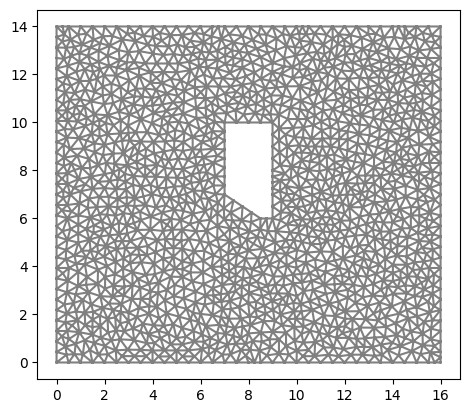

In [39]:
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H))  - houses, resolution)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

In [ ]:
K = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [ ]:
# Set permeability matrix
# Kinv11 = Expression('100.0*fabs(sin(2.0*pi*(x[1] - 0.1*x[0])))', element = K.ufl_element())
Kinv11 = Expression('100.0*exp(-((x[0]-2.5)*(x[0]-2.5) + (x[1]-2.0)*(x[1]-2.0))/0.06)', element = K.ufl_element())
Kinv12 = Expression('0.0', element = K.ufl_element())
Kinv21 = Kinv12
Kinv22 = Kinv11

# **Results**

**Define flow parameters**

In [ ]:
# # Set viscosity
# nu = 4.0e-3

#  --- Från Brinkman ---
# Set viscosity
nu = 1.0e-2

# Set effective viscosity
nueff = 1.0e-2

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
# Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
#     + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx

# Brinkman
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nueff*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
    + nu*(Kinv11*inner(um[0],v[0])*dx + Kinv12*inner(um[0],v[1])*dx + Kinv21*inner(um[1],v[0])*dx + Kinv22*inner(um[1],v[1])*dx)

au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10


time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
# T = 15
t = dt
start = tajm.time()
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)


        if (t > start_sample_time):
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")


        plot_time += T/plot_freq

        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

end = tajm.time()
print("Time elapsed: ", str((end - start)/60), "minutes")

# !tar -czvf results-NS.tar.gz results-NS
# files.download('results-NS.tar.gz')